# Setup

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import ast
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

Read in 2 dfs

In [2]:
# read in with removed comments df
with_removed_df = pd.read_csv('../../data/Reddit_cleaned_includes_removed.csv',  lineterminator='\n', encoding='utf8')

# read in with topic modeeling results df
topic_results_df = pd.read_csv('../../data/topic_model_results.csv',  lineterminator='\n', encoding='utf8')

add new column

In [3]:
with_removed_df['is_manual_removed'] = with_removed_df['text'].str.contains('removed', case=False, na=False).astype(bool)

In [4]:
with_removed_df[with_removed_df['is_manual_removed'] == True].head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation\r,is_manual_removed
3,removed,2020-01-03 16:44:46,[deleted],/r/singapore/comments/ej54sm/rsingapore_random...,t3_ej54sm,t1_fcxcdrx,fcxsm0g,t5_2qh8c,"{'removal_reason': None, 'collapsed': True, 'c...",True
35,removed,2021-03-03 01:07:41,[deleted],/r/singapore/comments/lvx1ai/london_mayor_earn...,t3_lvx1ai,t3_lvx1ai,gphdjxb,t5_2qh8c,"{'collapsed_reason_code': 'DELETED', 'collapse...",True
44,removed,2020-07-11 12:51:44,[deleted],/r/singapore/comments/hp74jj/the_hero_we_need_...,t3_hp74jj,t1_fxn50q9,fxnuenc,t5_2qh8c,"{'removal_reason': None, 'collapsed': True, 'c...",True
47,your submission has been removed because it do...,2020-07-01 13:12:38,AutoModerator,/r/singapore/comments/hj9wat/is_18m_considered...,t3_hj9wat,t3_hj9wat,fwkw3sw,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",True
60,removed,2020-12-26 09:44:10,[deleted],/r/singapore/comments/kk6tmr/rsingapore_random...,t3_kk6tmr,t1_gh1clxk,gh282rq,t5_2qh8c,"{'removal_reason': None, 'collapsed': True, 'c...",True


merge the 2 dfs

In [5]:
# List of columns to set to NaN for entries with "removed" in 'text'
columns_to_set_na = ['hateful Score', 'hateful HR', 'toxic Score', 'toxic HR\r', 'Topic Number', 'Topic\r']

# Create a mask for entries with "removed" in the 'text' column
removed_mask = with_removed_df['text'].str.contains('removed', case=False, na=False)

# Set these columns to NaN in a copy of topic_results_df before merging
topic_results_df.loc[removed_mask, columns_to_set_na] = np.nan

In [6]:
# Merge the two DataFrames on 'id', keeping all rows from both and using suffixes to differentiate any duplicate column names
results_df = pd.merge(with_removed_df, topic_results_df, on='id', how='outer', suffixes=('', '_duplicate'))

# Drop any duplicate columns created from the merge
# (for example, columns in topic_results_df that already exist in with_removed_df)
for col in results_df.columns:
    if '_duplicate' in col:
        results_df.drop(col, axis=1, inplace=True)

In [7]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Adjust width to avoid truncation

In [8]:
print(results_df)

                                                     text  \
0                                  the female or male cry   
1                                              double pay   
2                           this is one crazy bad morning   
3                                                 removed   
4       the crazy thing is most people on pmd really d...   
...                                                   ...   
439637  are you really gay or just playing around for ...   
439638  dont give me whatsboutism\n\nit is not traditi...   
439639  excellent should be compulsory for all singapo...   
439640                                                yes   
439641                             report to police db no   

                  timestamp        username  \
0       2020-01-01 00:12:59    Tempestuous-   
1       2020-01-01 00:38:33    Plyergamer27   
2       2020-01-01 00:42:09         gmdotes   
3       2020-01-01 00:48:57       [deleted]   
4       2020-01-01 00:55:10     

In [9]:
# Remove \r from column names
results_df.columns = results_df.columns.str.strip()

# Strip \r and other whitespace characters from a specific column (e.g., 'column_name')
results_df['Topic'] = results_df['Topic'].str.strip()

results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,is_manual_removed,hateful Score,hateful HR,toxic Score,toxic HR,Topic Number,Topic
0,the female or male cry,2020-01-01 00:12:59,Tempestuous-,/r/singapore/comments/ei9klf/rsingapore_random...,t3_ei9klf,t1_fcohcxx,fcoor03,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",False,-1.216313,0.0,-0.181924,0.0,2.0,Race & Religion
1,double pay,2020-01-01 00:38:33,Plyergamer27,/r/singapore/comments/ei5lec/lets_take_a_momen...,t3_ei5lec,t3_ei5lec,fcoqujj,t5_2qh8c,"{'removal_reason': None, 'collapsed': True, 'c...",False,-1.063543,0.0,-0.499782,0.0,2.0,Race & Religion
2,this is one crazy bad morning,2020-01-01 00:42:09,gmdotes,/r/singapore/comments/ehsyiu/rsingapore_random...,t3_ehsyiu,t1_fcnrh63,fcor57l,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",False,-1.007145,0.0,-0.369454,0.0,4.0,Relationships
3,removed,2020-01-01 00:48:57,[deleted],/r/singapore/comments/eibm65/premiumflea_marke...,t3_eibm65,t3_eibm65,fcorov8,t5_2qh8c,"{'removal_reason': None, 'collapsed': True, 'c...",True,NaN,NaN,NaN,NaN,NaN,NaN
4,the crazy thing is most people on pmd really d...,2020-01-01 00:55:10,jupiter1_,/r/singapore/comments/ei0oby/teen_pmd_rider_hi...,t3_ei0oby,t3_ei0oby,fcos6ik,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",False,-1.078415,0.0,-0.348272,0.0,1.0,Covid-19


In [10]:
# rename new columns
results_df.rename(columns={
    'hateful Score': 'hateful_score',
    'hateful HR': 'hateful_prediction',
    'toxic Score': 'toxic_score',
    'toxic HR': 'toxic_prediction',
    'Topic Number': 'topic_number',
    'Topic': 'topic'
}, inplace=True)

results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,is_manual_removed,hateful_score,hateful_prediction,toxic_score,toxic_prediction,topic_number,topic
0,the female or male cry,2020-01-01 00:12:59,Tempestuous-,/r/singapore/comments/ei9klf/rsingapore_random...,t3_ei9klf,t1_fcohcxx,fcoor03,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",False,-1.216313,0.0,-0.181924,0.0,2.0,Race & Religion
1,double pay,2020-01-01 00:38:33,Plyergamer27,/r/singapore/comments/ei5lec/lets_take_a_momen...,t3_ei5lec,t3_ei5lec,fcoqujj,t5_2qh8c,"{'removal_reason': None, 'collapsed': True, 'c...",False,-1.063543,0.0,-0.499782,0.0,2.0,Race & Religion
2,this is one crazy bad morning,2020-01-01 00:42:09,gmdotes,/r/singapore/comments/ehsyiu/rsingapore_random...,t3_ehsyiu,t1_fcnrh63,fcor57l,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",False,-1.007145,0.0,-0.369454,0.0,4.0,Relationships
3,removed,2020-01-01 00:48:57,[deleted],/r/singapore/comments/eibm65/premiumflea_marke...,t3_eibm65,t3_eibm65,fcorov8,t5_2qh8c,"{'removal_reason': None, 'collapsed': True, 'c...",True,NaN,NaN,NaN,NaN,NaN,NaN
4,the crazy thing is most people on pmd really d...,2020-01-01 00:55:10,jupiter1_,/r/singapore/comments/ei0oby/teen_pmd_rider_hi...,t3_ei0oby,t3_ei0oby,fcos6ik,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",False,-1.078415,0.0,-0.348272,0.0,1.0,Covid-19


In [11]:
# convert data to appropriate datatypes
results_df['text'] = results_df['text'].astype(str)
results_df['timestamp'] = pd.to_datetime(results_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
results_df['username'] = results_df['username'].astype(str)
results_df['link'] = results_df['link'].astype(str)
results_df['link_id'] = results_df['link_id'].astype(str)
results_df['parent_id'] = results_df['parent_id'].astype(str)
results_df['id'] = results_df['id'].astype(str)
results_df['subreddit_id'] = results_df['subreddit_id'].astype(str)
results_df['moderation'] = results_df['moderation'].tolist()
results_df['hateful_score'] = results_df['hateful_score'].astype('float32')
results_df['hateful_prediction'] = results_df['hateful_prediction'].astype('Int16')  # Nullable integer type
results_df['toxic_score'] = results_df['toxic_score'].astype('float32')
results_df['toxic_prediction'] = results_df['toxic_prediction'].astype('Int16')  # Nullable integer type
results_df['topic_number'] = results_df['topic_number'].astype('category')
results_df['topic'] = results_df['topic'].astype('category')

In [12]:
# Group by year and month to track moderation actions over time
results_df['year_month'] = results_df['timestamp'].dt.to_period('M')

# extract date from datetime stamp
results_df['timestamp'] = results_df['timestamp'].dt.date

results_df['timestamp'].head()

0    2020-01-01
1    2020-01-01
2    2020-01-01
3    2020-01-01
4    2020-01-01
Name: timestamp, dtype: object

In [18]:
results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,is_manual_removed,hateful_score,hateful_prediction,toxic_score,toxic_prediction,topic_number,topic,year_month
0,the female or male cry,2020-01-01,Tempestuous-,/r/singapore/comments/ei9klf/rsingapore_random...,t3_ei9klf,t1_fcohcxx,fcoor03,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",False,-1.216313,0,-0.181924,0,2.0,Race & Religion,2020-01
1,double pay,2020-01-01,Plyergamer27,/r/singapore/comments/ei5lec/lets_take_a_momen...,t3_ei5lec,t3_ei5lec,fcoqujj,t5_2qh8c,"{'removal_reason': None, 'collapsed': True, 'c...",False,-1.063543,0,-0.499782,0,2.0,Race & Religion,2020-01
2,this is one crazy bad morning,2020-01-01,gmdotes,/r/singapore/comments/ehsyiu/rsingapore_random...,t3_ehsyiu,t1_fcnrh63,fcor57l,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",False,-1.007145,0,-0.369454,0,4.0,Relationships,2020-01
3,removed,2020-01-01,[deleted],/r/singapore/comments/eibm65/premiumflea_marke...,t3_eibm65,t3_eibm65,fcorov8,t5_2qh8c,"{'removal_reason': None, 'collapsed': True, 'c...",True,NaN,<NA>,NaN,<NA>,NaN,NaN,2020-01
4,the crazy thing is most people on pmd really d...,2020-01-01,jupiter1_,/r/singapore/comments/ei0oby/teen_pmd_rider_hi...,t3_ei0oby,t3_ei0oby,fcos6ik,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",False,-1.078415,0,-0.348271,0,1.0,Covid-19,2020-01


# 1. boxplot of toxicity of subreddits

In [14]:
subreddits_of_interest = results_df['subreddit_id'].unique()
subreddits_of_interest

array(['t5_2qh8c', 't5_xnx04', 't5_70s6ew'], dtype=object)

C:\Users\caleb\AppData\Local\Temp\ipykernel_17144\136131929.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=results_df, x='subreddit_id', y='toxic_score', order=subreddits_of_interest, palette=palette, whis = 200)


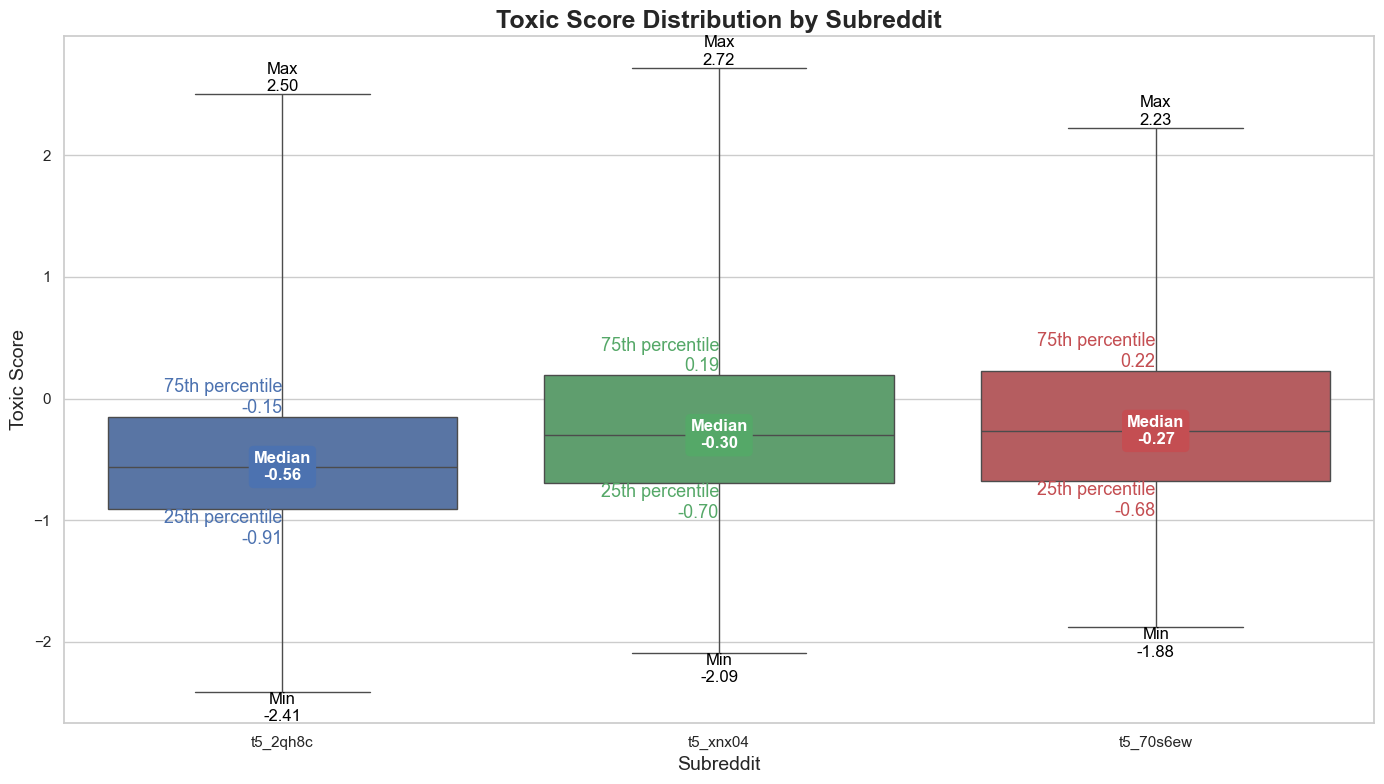

In [19]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a box plot with a custom color palette
plt.figure(figsize=(14, 8))
palette = {"t5_2qh8c": "#4c72b0", "t5_xnx04": "#55a868", "t5_70s6ew": "#c44e52"}
ax = sns.boxplot(data=results_df, x='subreddit_id', y='toxic_score', order=subreddits_of_interest, palette=palette, whis = 200)

# Annotate median, first quartile (Q1), and third quartile (Q3) for each subreddit
for i, subreddit in enumerate(subreddits_of_interest):
    subreddit_data = results_df[results_df['subreddit_id'] == subreddit]['toxic_score']
    median = subreddit_data.median()
    q1 = subreddit_data.quantile(0.25)
    q3 = subreddit_data.quantile(0.75)
    min_val = subreddit_data.min()
    max_val = subreddit_data.max()
    
    # Median label
    ax.text(i, median, f'Median\n{median:.2f}', ha='center', va='center', color='white', fontweight='bold',
            bbox=dict(facecolor=palette[subreddit], edgecolor='none', boxstyle='round,pad=0.3'))
    # Q1 and Q3 labels
    ax.text(i, q1, f'25th percentile\n{q1:.2f}', ha='right' , va= 'top', color=palette[subreddit], fontsize=13)
    ax.text(i, q3, f'75th percentile\n{q3:.2f}', ha='right', va='bottom', color=palette[subreddit], fontsize=13)
    # Min and Max labels
    ax.text(i, min_val, f'Min\n{min_val:.2f}', ha='center', va='top', color='black', fontsize=12)
    ax.text(i, max_val, f'Max\n{max_val:.2f}', ha='center', va='bottom', color='black', fontsize=12)

# Set title and labels
plt.title('Toxic Score Distribution by Subreddit', fontsize=18, fontweight='bold')
plt.xlabel('Subreddit', fontsize=14)
plt.ylabel('Toxic Score', fontsize=14)

# Improve spacing and add legend for clarity
plt.tight_layout()

# Display the plot
plt.show()